In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import scipy.stats as st
import polars as pl
import polars.selectors as cs
from colored import Fore, Style

In [2]:
data=pd.read_csv('PricePredictionData/data.csv')

In [3]:
data.shape

(11621, 18)

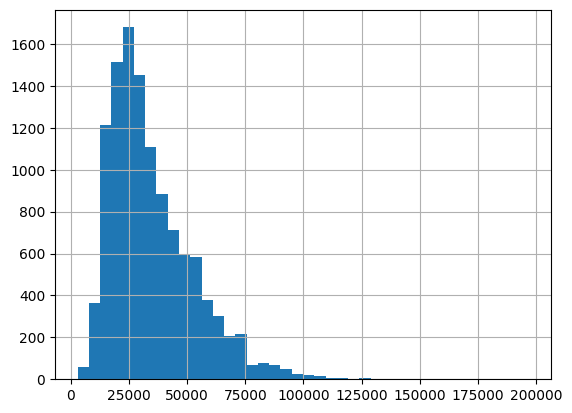

In [4]:
data['priceUnformatted'].hist(bins=40);

Let's get a first taste on a Bagging ensemble regressor performance. We know a priori it's going to be bad bacause of the majority of cars being priced 20.000 - 60.000 dollars.

In [5]:
x, y=data.drop('priceUnformatted', axis=1), data['priceUnformatted']

bg_reg=BaggingRegressor(estimator=DecisionTreeRegressor(criterion='friedman_mse', splitter='best', 
                                                        min_samples_leaf=20, min_samples_split=40), 
                        n_estimators=20, max_samples=0.4, max_features=0.4, bootstrap=False)

bg_reg_scores=np.sqrt(-cross_val_score(bg_reg, x, y, cv=20, scoring='neg_mean_squared_error'))

print(st.t.interval(confidence=0.95, df=len(bg_reg_scores)-1, loc=np.mean(bg_reg_scores), scale=st.sem(bg_reg_scores)))

(9687.540559934392, 11556.11847825131)


Despite the 'ok' confidence interval of the model, we are suspicious of what is happening at the ends of the distribution we saw above.
So we are splitting the dataset into 3 (sub 20k, 20k-60k, above 60k) parts and checking the error there.

In [6]:
bg_reg.fit(x, y);

split_points=[20000, 60000]
first_bin=data[data['priceUnformatted'] <= split_points[0]]
print(f'Number of cars sub 20.000 dollars: {Fore.green}{first_bin.shape[0]}{Style.reset}')

sec_bin=data[(data['priceUnformatted'] > split_points[0]) & (data['priceUnformatted'] <= split_points[1])]
print(f'Number of cars between 20.000 - 60.000 dollars: {Fore.red}{sec_bin.shape[0]}{Style.reset}')

third_bin=data[data['priceUnformatted'] > split_points[1]]
print(f'Number of cars over 60.000 dollars: {Fore.blue}{third_bin.shape[0]}')

Number of cars sub 20.000 dollars: 2493
Number of cars between 20.000 - 60.000 dollars: 7989
Number of cars over 60.000 dollars: 1139


In [7]:
# Price range <= 20_000
mean_absolute_error(bg_reg.predict(first_bin.drop('priceUnformatted', axis=1)), first_bin.priceUnformatted.values)

6294.118672745965

MAE of 6041 for cars below 20.000 dollars is pretty bad. Consider the scenario were a car should be priced around 5k-6k dollars and my predictions is 10k or 0 dollars. It is just unacceptable.

We are going to check distribution plots of true versus predicted prices. If the distributions are similar then the model's performance is
good, if the distributions don't even overlap than the model is useless for the particular segment.

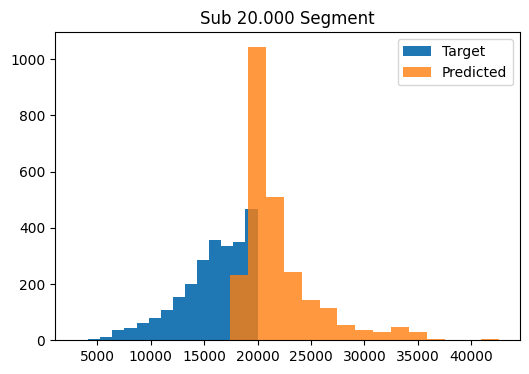

In [8]:
plt.figure(figsize=(6, 4))
plt.hist(first_bin.priceUnformatted.values, label='Target', bins=15)
plt.hist(bg_reg.predict(first_bin.drop('priceUnformatted', axis=1)), label='Predicted', bins=15, alpha=0.8)
plt.legend()
plt.title('Sub 20.000 Segment');

As we predicted, the distributions do not seem similar at all, they even diverge from each other.

In [9]:
# Price range  20_000 - 60_000
mean_absolute_error(bg_reg.predict(sec_bin.drop('priceUnformatted', axis=1)), sec_bin.priceUnformatted.values)

4379.247698698259

MAE of 4596 seems ok, but thats expected considering the majority of the dataset lies in that region. It can also be seen
from the plot below that the two distributions overlap greatly.

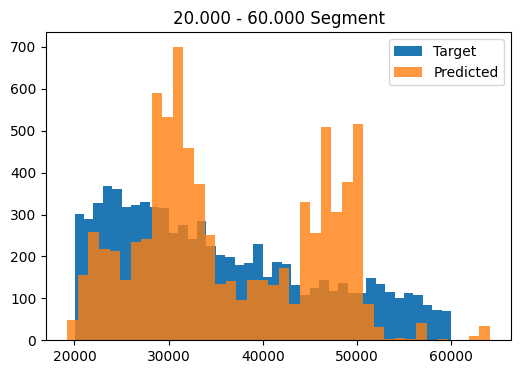

In [10]:
plt.figure(figsize=(6, 4))
plt.hist(sec_bin.priceUnformatted.values, label='Target', bins=40)
plt.hist(bg_reg.predict(sec_bin.drop('priceUnformatted', axis=1)), label='Predicted', bins=40, alpha=0.8)
plt.legend()
plt.title('20.000 - 60.000 Segment');

In [11]:
# Price range > 60_000
mean_absolute_error(bg_reg.predict(third_bin.drop('priceUnformatted', axis=1)), third_bin.priceUnformatted.values)

20967.730528197982

Here we have the same scenario as in the 1st segment, where the error for the segment is pretty big and the two distributions seem to diverge from each other.

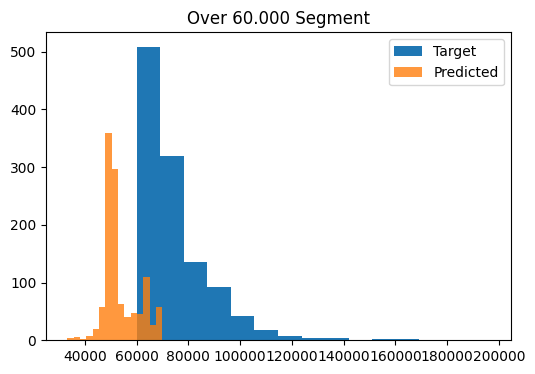

In [12]:
plt.figure(figsize=(6, 4))
plt.hist(third_bin.priceUnformatted.values, label='Target', bins=15)
plt.hist(bg_reg.predict(third_bin.drop('priceUnformatted', axis=1)), label='Predicted', bins=15, alpha=0.8)
plt.legend()
plt.title('Over 60.000 Segment');

It's clear that because of the majority of car prices in the dataset are in the range between 20k and 60k the model is not that accurate in the sub 20k and over 60k segments.

So we will use 3 different models of the same algorithm to get a better performance.

In [18]:
reg_bin_1=BaggingRegressor(estimator=DecisionTreeRegressor(criterion='friedman_mse', splitter='best', 
                                                           min_samples_leaf=15, min_samples_split=30),
                           n_estimators=10, max_samples=0.4, max_features=0.4, bootstrap=False)

reg_bin_2=BaggingRegressor(estimator=DecisionTreeRegressor(criterion='friedman_mse', splitter='best', 
                                                           min_samples_leaf=20, min_samples_split=40),
                           n_estimators=20, max_samples=0.4, max_features=0.4, bootstrap=False)

reg_bin_3=BaggingRegressor(estimator=DecisionTreeRegressor(criterion='friedman_mse', splitter='best', 
                                                           min_samples_leaf=15, min_samples_split=30),
                           n_estimators=20, max_samples=0.2, max_features=0.2, bootstrap=False)

reg_bin_1_scores=-cross_val_score(reg_bin_1, first_bin.drop('priceUnformatted', axis=1), 
                                  first_bin.priceUnformatted, cv=5, scoring='neg_mean_absolute_error')

reg_bin_2_scores=-cross_val_score(reg_bin_2, sec_bin.drop('priceUnformatted', axis=1), 
                                  sec_bin.priceUnformatted, cv=10, scoring='neg_mean_absolute_error')

reg_bin_3_scores=-cross_val_score(reg_bin_3, third_bin.drop('priceUnformatted', axis=1),
                                  third_bin.priceUnformatted, cv=4, scoring='neg_mean_absolute_error')

print(st.t.interval(confidence=0.95, df=len(reg_bin_1_scores)-1, loc=np.mean(reg_bin_1_scores), scale=st.sem(reg_bin_1_scores)))

print(st.t.interval(confidence=0.95, df=len(reg_bin_2_scores)-1, loc=np.mean(reg_bin_2_scores), scale=st.sem(reg_bin_2_scores)))

print(st.t.interval(confidence=0.95, df=len(reg_bin_3_scores)-1, loc=np.mean(reg_bin_3_scores), scale=st.sem(reg_bin_3_scores)))

(1782.0511173694335, 2128.867847020647)
(5188.950734247394, 5697.266781092162)
(8774.20895623237, 10854.527783724414)


In [19]:
reg_bin_1.fit(first_bin.drop('priceUnformatted', axis=1), first_bin.priceUnformatted);
reg_bin_2.fit(sec_bin.drop('priceUnformatted', axis=1), sec_bin.priceUnformatted);
reg_bin_3.fit(third_bin.drop('priceUnformatted', axis=1), third_bin.priceUnformatted);

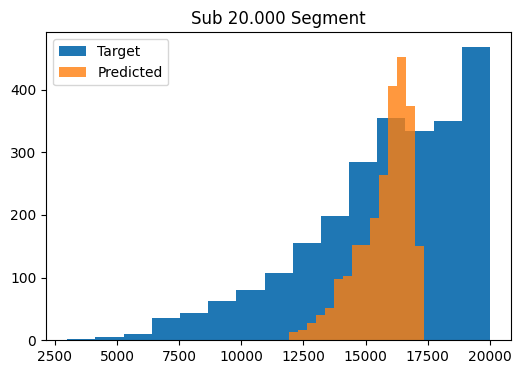

In [20]:
plt.figure(figsize=(6, 4))
plt.hist(first_bin.priceUnformatted.values, label='Target', bins=15)
plt.hist(reg_bin_1.predict(first_bin.drop('priceUnformatted', axis=1)), label='Predicted', bins=15, alpha=0.8)
plt.legend()
plt.title('Sub 20.000 Segment');

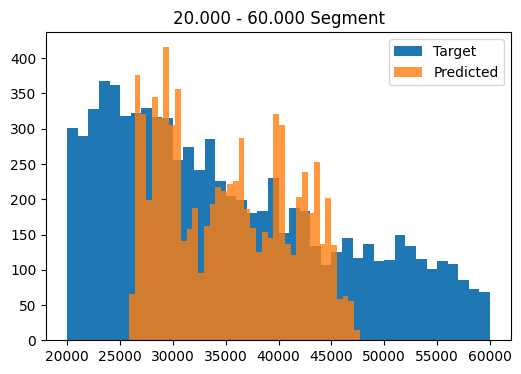

In [21]:
plt.figure(figsize=(6, 4))
plt.hist(sec_bin.priceUnformatted.values, label='Target', bins=40)
plt.hist(reg_bin_2.predict(sec_bin.drop('priceUnformatted', axis=1)), label='Predicted', bins=40, alpha=0.8)
plt.legend()
plt.title('20.000 - 60.000 Segment');

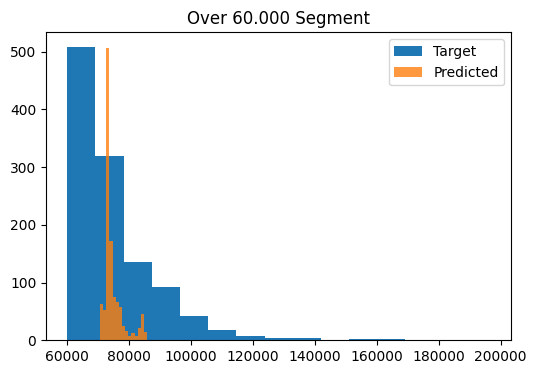

In [22]:
plt.figure(figsize=(6, 4))
plt.hist(third_bin.priceUnformatted.values, label='Target', bins=15)
plt.hist(reg_bin_3.predict(third_bin.drop('priceUnformatted', axis=1)), label='Predicted', bins=15, alpha=0.8)
plt.legend()
plt.title('Over 60.000 Segment');

## Comments

We see that when using one regressor for the whole dataset the performance in two segments is terrible, while the performance of the middle one (20k - 60k) is relatively the same. The distributions of target and predicted values do not even overlap in those 2 segments. In contrast when using 3 separate regressors, one for each segment, we see that the distributions now overlap indicating better bevavior.

In [23]:
data=pl.scan_csv('PricePredictionData/data.csv').collect()
split_datasets = dict()
split_regressors = dict()
split_metrics = dict()
num_of_splits = 8
split_step = 100_000/num_of_splits

for split in range(1, num_of_splits+1):
    upper_b = split*split_step
    lower_b = (split-1)*split_step
    if split==num_of_splits:
        split_datasets[f'split_{split}'] = data.filter(pl.col('priceUnformatted') >= lower_b)
    else:
        split_datasets[f'split_{split}'] = data.filter((pl.col('priceUnformatted') >= lower_b) & (pl.col('priceUnformatted') < upper_b))

for split_key in split_datasets.keys():
    # create the classifiers
    split_regressors[split_key+'_regressor'] = BaggingRegressor(estimator=DecisionTreeRegressor(criterion='friedman_mse', splitter='best',
                           min_samples_leaf=15, min_samples_split=30),
                           n_estimators=10, max_samples=0.4, max_features=0.4, bootstrap=False)
    # target column
    target_col = split_datasets[split_key]['priceUnformatted']
    # compute cross validation scores
    cv_losses=np.sqrt(-cross_val_score(split_regressors[split_key+'_regressor'],
                                       split_datasets[split_key].drop('priceUnformatted'),
                                       target_col, 
                                       cv=10, scoring='neg_mean_squared_error'))
    # store the 95% confidence intervals for the error of each classifier
    split_metrics[split_key+'_metrics'] = st.t.interval(confidence=0.95, 
                                                        df=len(cv_losses)-1, 
                                                        loc=np.mean(cv_losses), 
                                                        scale=st.sem(cv_losses))
    # train each classifier on their segment
    split_regressors[split_key+'_regressor'].fit(split_datasets[split_key].drop('priceUnformatted'), target_col)

# create a segment column
for i in range(1, num_of_splits+1):
    data=data.with_columns(pl.when(pl.col('priceUnformatted') < split_step*i)
                           .then(pl.lit(i))
                           .otherwise(pl.lit(None))
                           .alias('segment_'+str(i)))
data=data.with_columns(segment=pl.min_horizontal(cs.starts_with("segment_"))).drop(cs.starts_with('segment_'))

In [24]:
split_metrics

{'split_1_metrics': (1637.9011538139239, 1920.017396352553),
 'split_2_metrics': (2717.525458619755, 2998.7498121111694),
 'split_3_metrics': (2889.36378241875, 3127.3267652384193),
 'split_4_metrics': (3249.5459872391248, 3439.1631196302815),
 'split_5_metrics': (3218.1180255084455, 3495.387067547972),
 'split_6_metrics': (3422.729846121127, 3764.844509553371),
 'split_7_metrics': (3618.8187532590455, 4205.578884617355),
 'split_8_metrics': (11880.37341030369, 19658.77684967609)}

## Deployment Test

The user might not know all the features of the car we ask to make a prediction, so the car could be showing up in multiple segments and the algorithm won't know what model to use. We must make a function to tackle this problem of the queried model showing up at multiple segments at once. Firstly, we have to make sure that the models work with NA values.

In [25]:
data.drop(['segment', 'priceUnformatted'])[9]

year,modelId,mileageUnformatted,cylinder_engine,size_engine,horsepower_engine,torque_engine,highway_mpg,city_mpg,make,condition,bodyStyle,configuration_engine,type_engine,name_transmission,drivenWheels,market_categories
i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64
2013,2006.0,34527.0,0.0,null,null,null,null,null,36,2,6,4,1,1,3,45


In [26]:
split_regressors['split_1_regressor'].predict(data.drop(['segment', 'priceUnformatted'])[9])

array([9606.02673097])

It works, as it was supposed to. That's why we selected that algorithm in the first place.

Now, suppose that the user inserts only a few fields like Make, Model and Year.

In [27]:
dummy=data.filter(pl.col('modelId') == 862).filter((pl.col('year') == 2021))
dummy['segment'].value_counts().sort('segment')

segment,count
i32,u32
2,14
3,1
4,3


In [69]:
def get_pred(data, make, modelId, year, mileageUnformatted=None, cylinder_engine=None, size_engine=None, horsepower_engine=None, 
             torque_engine=None, highway_mpg=None, city_mpg=None, condition=None, bodyStyle=None, configuration_engine=None, 
             type_engine=None, name_transmission=None, drivenWheels=None, market_categories=None):
    
    # fields the user is going to pass to the app to get a suggestion
    filter_dict={'year': year,
                 'modelId': modelId,
                 'mileageUnformatted': mileageUnformatted,
                 'cylinder_engine': cylinder_engine,
                 'size_engine': size_engine,
                 'horsepower_engine': horsepower_engine,
                 'torque_engine': torque_engine,
                 'highway_mpg': highway_mpg,
                 'city_mpg': city_mpg,
                 'make': make,
                 'condition': condition,
                 'bodyStyle': bodyStyle,
                 'configuration_engine': configuration_engine,
                 'type_engine': type_engine,
                 'name_transmission': name_transmission,
                 'drivenWheels': drivenWheels,
                 'market_categories': market_categories}
    
    data=data
    # turn fields to an array in order to make the prediction
    query=pl.from_dict(filter_dict)
    # filter the dataset in order to get the correct vehicle
    for key in filter_dict.keys():
        if filter_dict[key] is not None:
            data=data.filter(pl.col(key) == filter_dict[key])
    # find the segments the vehicle belongs to
    data=data['segment'].value_counts().sort('segment').with_columns(freq=pl.col('count')/len(data)).drop('count')

    queried_regressors=[]
    queried_metrics=[]
    # get the correct regressors and confidence intervals
    for i in data['segment']:
        queried_regressors.append(split_regressors['split_'+str(i)+'_regressor'])
        queried_metrics.append(split_metrics['split_'+str(i)+'_metrics'])

    # make the prediction
    prediction=0
    upper_bound=0
    lower_bound=0
    for j in range(len(data)):
        prediction+=data['freq'][j]*queried_regressors[j].predict(query).item()
        upper_bound+=data['freq'][j]*queried_metrics[j][1]
        lower_bound+=data['freq'][j]*queried_metrics[j][0]
        
    return prediction, upper_bound, lower_bound

In [70]:
get_pred(data, None, 862, 2021)

(24455.743224437865, 3079.2951940936464, 2815.742120267372)